# OpenAQ PM 2.5 Prediction

## Imports and Setup

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openaq import OpenAQ
import optuna
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

/Users/kdevoe/Documents/CS/Masters/AAI540/AAI540-final-project/540_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters
RADIUS = 10_000
LIMIT = 4
DATE_RANGE = [datetime.now() - timedelta(days=1), datetime.now()]
TARGET_PARAM = "pm25"

LOCATIONS_DICT = {
    "Canyon ES (2795)": 947312,
    "Pacific Palisades ES (5959)": 947232,
    "Revere MS (8356)": 947280,
    "Brentwood Sci Mag ES (2507)": 947305,
}

### OpenAQ API Setup and Data Retrieval

In [3]:
# Put your OpenAQ API key in a text file with the name "openaq_api_key.txt"
with open("api_keys/openaq_api_key.txt", "r") as file:
    API_KEY = file.read()

# Initialize the OpenAQ client
client = OpenAQ(api_key=API_KEY)

In [4]:
# Function to fetch sensor data near a given location, return a dataframe where each row is a sensor and has data about the location and one column contains the measurements
def fetch_nearby_sensors(latitude, longitude, radius=10_000, limit=3):
    # Get the locations near the given coordinates
    response = client.locations.list(coordinates=(latitude, longitude), radius=radius, limit=limit)

    format_string = "%Y-%m-%dT%H:%M:%SZ"
    data = {}
    m_id = 0
    # For each location in the response, fetch its sensors
    for location in response.results:
        for sensor in location.sensors:
            lat = location.coordinates.latitude
            long = location.coordinates.longitude
            loc_name = location.name
            location_id = location.id
            sensor = sensor.id

            # Fetch the recent measurements the sensor
            measurements = client.measurements.list(sensor)

            # For each measurement, record the relevant data
            for measurement in measurements.results:
                m_id += 1
                epoch = datetime.strptime(measurement.period.datetime_from.utc, format_string)
                duration = timedelta(seconds=pd.to_timedelta(measurement.period.interval).seconds)
                parameter = measurement.parameter.name
                value = measurement.value
                units = measurement.parameter.units

                data[m_id] = {
                    "measurement_id": m_id,
                    "sensor_id": sensor,
                    "location_id": location_id,
                    "location": loc_name,
                    "latitude": lat,
                    "longitude": long,
                    "epoch": epoch,
                    "duration": duration,
                    "parameter": parameter,
                    "value": value,
                    "units": units,
                }

    return pd.DataFrame.from_dict(data, orient="index")

In [5]:
def fetch_sensors_by_list(sensor_list):
    format_string = "%Y-%m-%dT%H:%M:%SZ"
    data = {}
    m_id = 0
    # For each location in the response, fetch its sensors
    for id in sensor_list:
        location = client.locations.get(id).results[0]
        print(f"""Fetching {location.name} data""")
        for sensor in location.sensors:
            lat = location.coordinates.latitude
            long = location.coordinates.longitude
            loc_name = location.name
            location_id = location.id
            sensor = sensor.id

            # Fetch the recent measurements the sensor
            measurements = client.measurements.list(sensor)

            # For each measurement, record the relevant data
            for measurement in measurements.results:
                m_id += 1
                epoch = datetime.strptime(measurement.period.datetime_from.utc, format_string)
                duration = timedelta(seconds=pd.to_timedelta(measurement.period.interval).seconds)
                parameter = measurement.parameter.name
                value = measurement.value
                units = measurement.parameter.units

                data[m_id] = {
                    "measurement_id": m_id,
                    "sensor_id": sensor,
                    "location_id": location_id,
                    "location": loc_name,
                    "latitude": lat,
                    "longitude": long,
                    "epoch": epoch,
                    "duration": duration,
                    "parameter": parameter,
                    "value": value,
                    "units": units,
                }

    return pd.DataFrame.from_dict(data, orient="index")

In [6]:
# Example: Get sensors within 10km of Los Angeles (34.0549, -118.2426)
# df = fetch_nearby_sensors(latitude=34.03213, longitude=-118.51198, radius=RADIUS, limit=LIMIT)

# Get only the first location for time series analysis
df = fetch_sensors_by_list([list(LOCATIONS_DICT.values())[0]])

Fetching Canyon ES (2795) data


## Exploratory Data Analysis

In [7]:
# Display results
df.head()

# To csv
df.to_csv("data/sensor_data.csv", index=False)


In [8]:
# Basic Info
print("Basic Info:")
print(df.info())

Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 5000
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   measurement_id  5000 non-null   int64          
 1   sensor_id       5000 non-null   int64          
 2   location_id     5000 non-null   int64          
 3   location        5000 non-null   object         
 4   latitude        5000 non-null   float64        
 5   longitude       5000 non-null   float64        
 6   epoch           5000 non-null   datetime64[ns] 
 7   duration        5000 non-null   timedelta64[ns]
 8   parameter       5000 non-null   object         
 9   value           5000 non-null   float64        
 10  units           5000 non-null   object         
dtypes: datetime64[ns](1), float64(3), int64(3), object(3), timedelta64[ns](1)
memory usage: 468.8+ KB
None


In [9]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
measurement_id    0
sensor_id         0
location_id       0
location          0
latitude          0
longitude         0
epoch             0
duration          0
parameter         0
value             0
units             0
dtype: int64


In [10]:
# Summary Statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       measurement_id     sensor_id  location_id    latitude     longitude  \
count     5000.000000  5.000000e+03       5000.0  5000.00000  5.000000e+03   
mean      2500.500000  3.298218e+06     947312.0    34.03213 -1.185120e+02   
min          1.000000  2.000855e+06     947312.0    34.03213 -1.185120e+02   
25%       1250.750000  2.000858e+06     947312.0    34.03213 -1.185120e+02   
50%       2500.500000  2.000861e+06     947312.0    34.03213 -1.185120e+02   
75%       3750.250000  5.244258e+06     947312.0    34.03213 -1.185120e+02   
max       5000.000000  5.244259e+06     947312.0    34.03213 -1.185120e+02   
std       1443.520003  1.589094e+06          0.0     0.00000  1.421228e-14   

                               epoch                   duration        value  
count                           5000                       5000  5000.000000  
mean   2022-08-31 19:18:15.748999936            0 days 00:03:48    13.509264  
min              2022-02-18 01:54:32   

In [11]:
# Show unique location ids in dataset

locations = df["location_id"].unique()
print("\nUnique Location IDs: ", locations)
print("Number of location ids:", len(locations))


Unique Location IDs:  [947312]
Number of location ids: 1


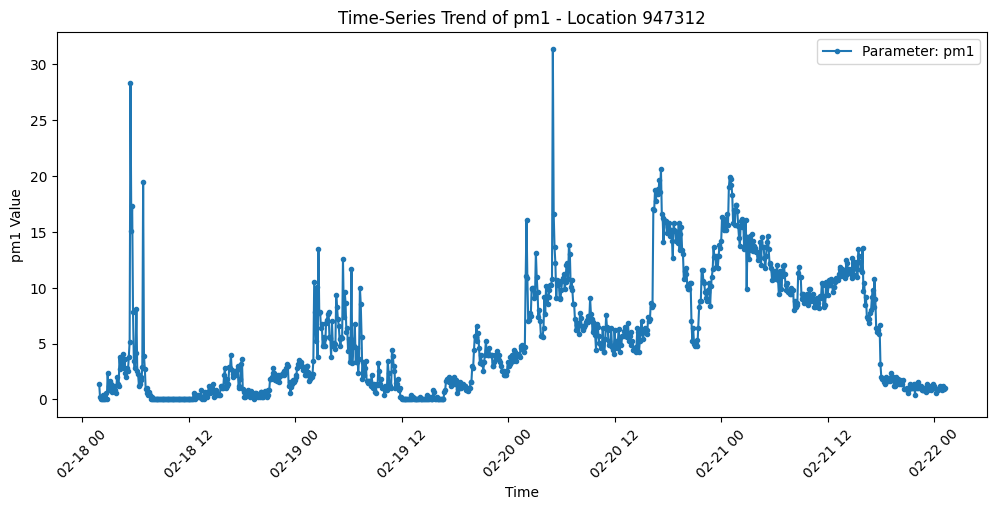

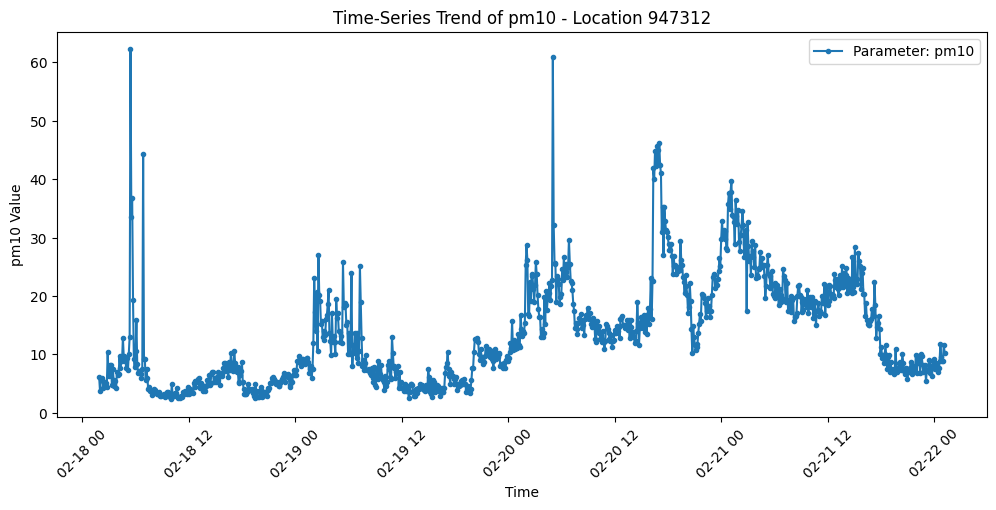

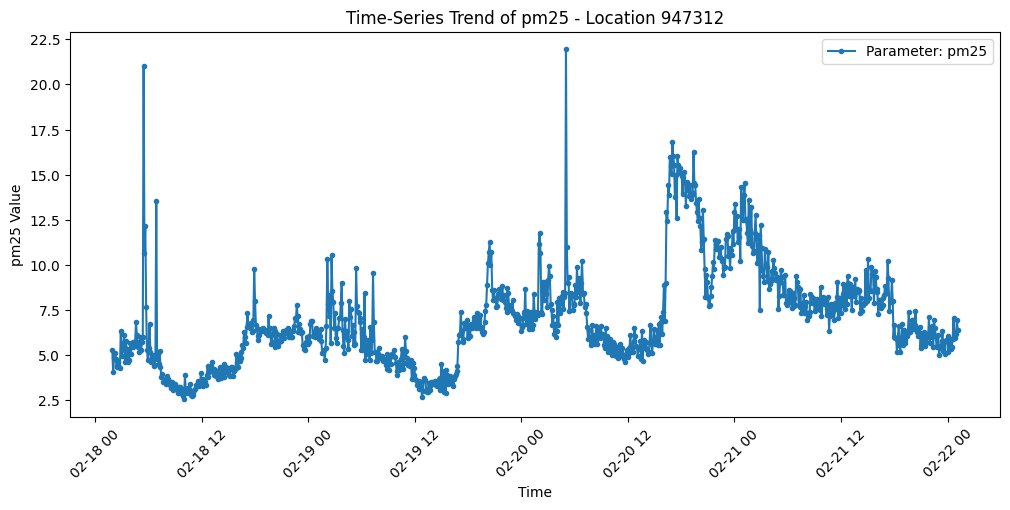

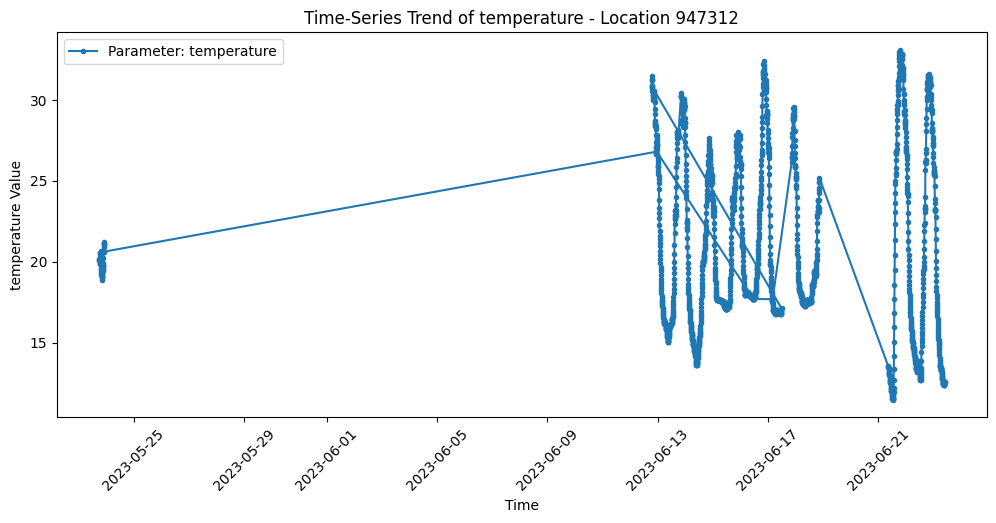

In [12]:
# Loop through each unique location_id
for location in df["location_id"].unique():
    df_location = df[df["location_id"] == location]  # Filter data for this location

    # Loop through each unique parameter
    for parameter in df_location["parameter"].unique():
        df_param = df_location[
            df_location["parameter"] == parameter
        ]  # Filter data for this parameter

        plt.figure(figsize=(12, 5))
        plt.plot(
            df_param["epoch"],
            df_param["value"],
            marker="o",
            linestyle="-",
            markersize=3,
            label=f"Parameter: {parameter}",
        )
        plt.xlabel("Time")
        plt.ylabel(f"{parameter} Value")
        plt.title(f"Time-Series Trend of {parameter} - Location {location}")
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

### Review Spacing Between Data Points

Check to see if there are any large gaps in the data or inconsistencies in the time intervals between data points.

['pm1' 'pm10' 'pm25' 'temperature']


/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_33461/1850392205.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_param["gap_size"] = df_param["epoch"].diff().dt.total_seconds().fillna(0)


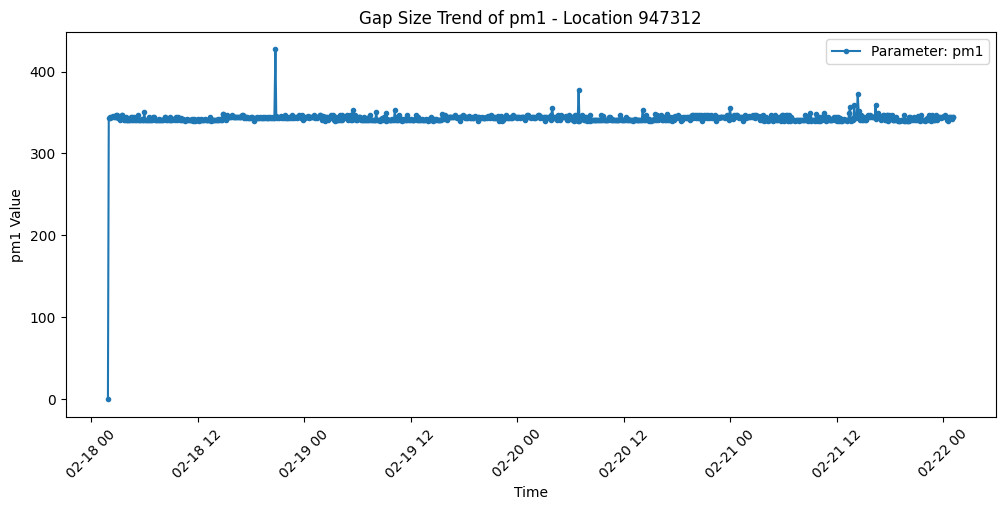

/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_33461/1850392205.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_param["gap_size"] = df_param["epoch"].diff().dt.total_seconds().fillna(0)


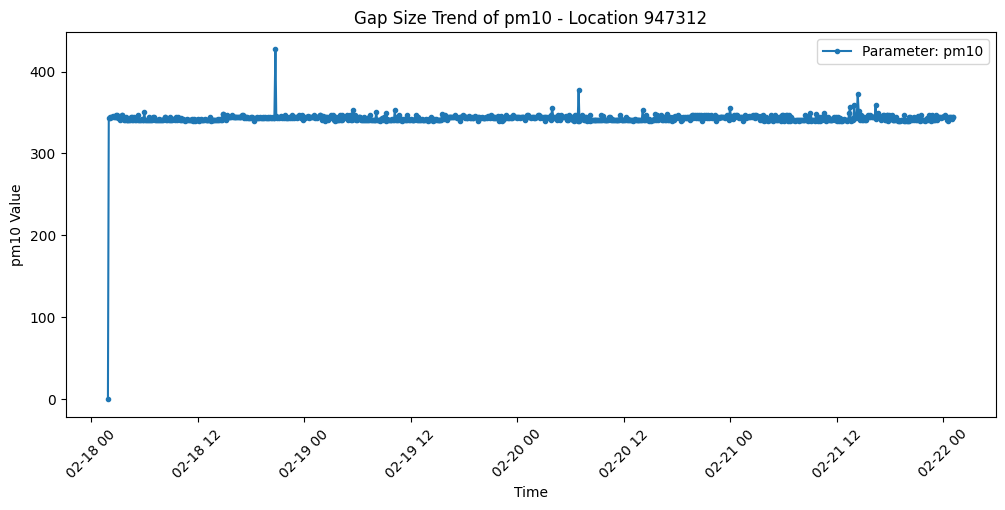

/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_33461/1850392205.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_param["gap_size"] = df_param["epoch"].diff().dt.total_seconds().fillna(0)


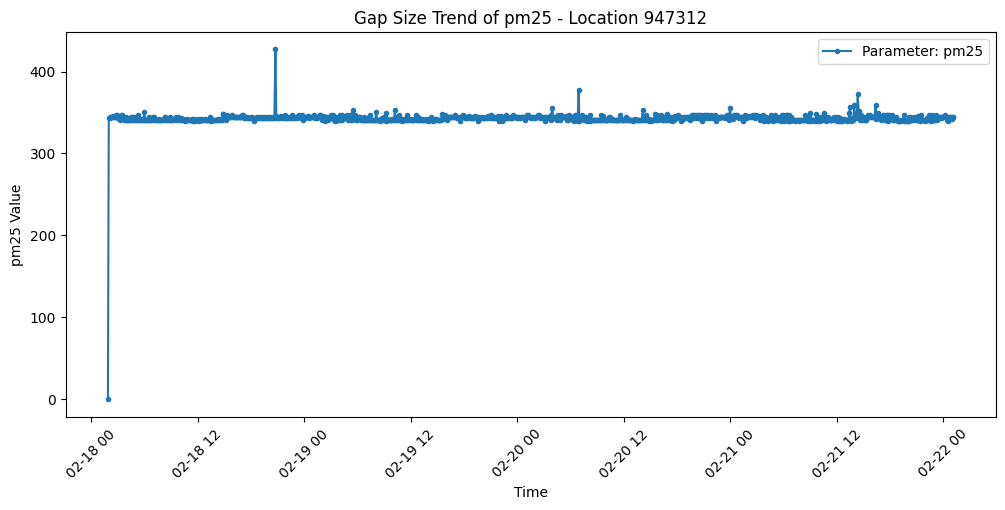

/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_33461/1850392205.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_param["gap_size"] = df_param["epoch"].diff().dt.total_seconds().fillna(0)


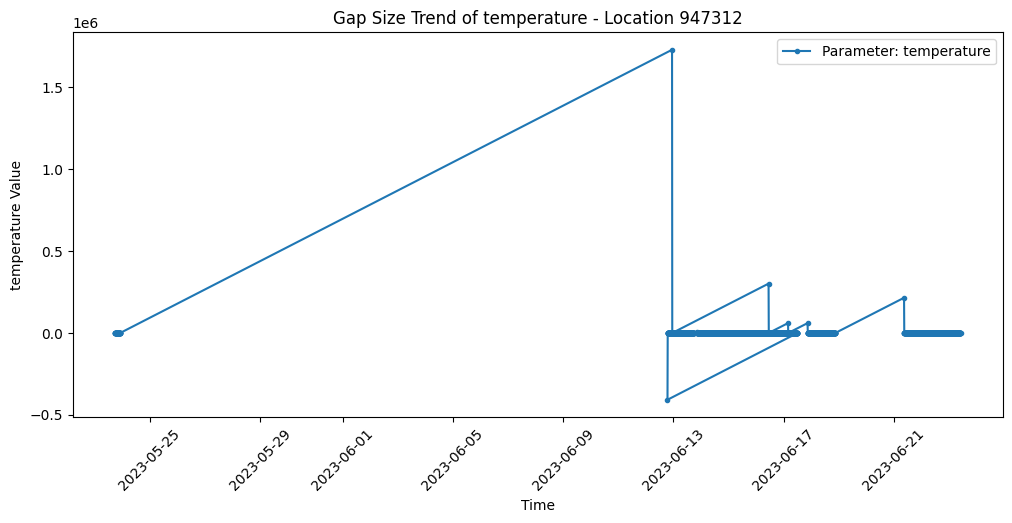

In [13]:
location_id = 947312

df_location = df[df["location_id"] == location_id]  # Filter data for this location

print(df_location["parameter"].unique())

for parameter in df_location["parameter"].unique():
    df_param = df_location[df_location["parameter"] == parameter]  # Filter data for this parameter

    df_param["gap_size"] = df_param["epoch"].diff().dt.total_seconds().fillna(0)

    plt.figure(figsize=(12, 5))
    plt.plot(
        df_param["epoch"],
        df_param["gap_size"],
        marker="o",
        linestyle="-",
        markersize=3,
        label=f"Parameter: {parameter}",
    )
    plt.xlabel("Time")
    plt.ylabel(f"{parameter} Value")
    plt.title(f"Gap Size Trend of {parameter} - Location {location_id}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

## Part 2: Time Series Modeling

Split Data

In [14]:
TRAIN_SPLIT = 0.4
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
PROD_SPLIT = 0.4

SEQ_LEN = 20
PRED_LEN = 1

In [17]:
# Split training
df_param = df_location[df_location["parameter"] == TARGET_PARAM]  # Filter data for this parameter
train_data = df_param.iloc[: int(len(df_param) * TRAIN_SPLIT)]
train_data = train_data.reset_index(drop=True)

# Split validation
val_data = df_param.iloc[
    int(len(df_param) * TRAIN_SPLIT) : int(len(df_param) * TRAIN_SPLIT)
    + int(len(df_param) * VAL_SPLIT)
]
val_data = val_data.reset_index(drop=True)

# Split testing
test_data = df_param.iloc[
    int(len(df_param) * TRAIN_SPLIT) + int(len(df_param) * VAL_SPLIT) : int(
        len(df_param) * TRAIN_SPLIT
    )
    + int(len(df_param) * VAL_SPLIT)
    + int(len(df_param) * TEST_SPLIT)
]
test_data = test_data.reset_index(drop=True)

# Split production
prod_data = df_param.iloc[
    int(len(df_param) * TRAIN_SPLIT)
    + int(len(df_param) * VAL_SPLIT)
    + int(len(df_param) * TEST_SPLIT) :
]
prod_data = prod_data.reset_index(drop=True)

In [ ]:
prod_data.to_csv("data/production_data.csv", index=False)

In [18]:
# Normalize the training dataset
scaler = StandardScaler()
train_data.loc[:, "value"] = scaler.fit_transform(train_data["value"].values.reshape(-1, 1))
val_data.loc[:, "value"] = scaler.transform(val_data["value"].values.reshape(-1, 1))
test_data.loc[:, "value"] = scaler.transform(test_data["value"].values.reshape(-1, 1))

In [24]:
import joblib

joblib.dump(scaler, "scaler.pkl")

scaler = joblib.load("scaler.pkl")

print("Scaler Mean:", scaler.mean_)
print("Scaler Std Dev:", scaler.scale_)

Scaler Mean: [5.186675]
Scaler Std Dev: [1.74470992]


In [19]:
# Check the shape of the different datasets

print("Train Data Shape:", train_data.shape)
print("Validation Data Shape:", val_data.shape)
print("Test Data Shape:", test_data.shape)
print("Production Data Shape:", prod_data.shape)

Train Data Shape: (400, 11)
Validation Data Shape: (100, 11)
Test Data Shape: (100, 11)
Production Data Shape: (400, 11)


In [20]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len=30, pred_len=1):
        """
        Args:
        - data (pd.DataFrame or np.array): Time series values
        - seq_len (int): Number of time steps in input sequence
        - pred_len (int): Number of time steps in output sequence
        """
        self.data = np.array(data["value"]) if isinstance(data, pd.DataFrame) else np.array(data)
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        """Returns total number of sequences available"""
        return max(0, len(self.data) - self.seq_len - self.pred_len)

    def __getitem__(self, idx):
        """Retrieves input sequence and target sequence"""
        if idx >= len(self):
            raise IndexError(f"Index {idx} out of bounds for dataset length {len(self)}")

        x = self.data[idx : idx + self.seq_len]
        y = self.data[idx + self.seq_len : idx + self.seq_len + self.pred_len]

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [21]:
# Create DataLoaders
BATCH_SIZE = 8

train_dataset = TimeSeriesDataset(train_data, seq_len=SEQ_LEN, pred_len=PRED_LEN)
val_dataset = TimeSeriesDataset(val_data, seq_len=SEQ_LEN, pred_len=PRED_LEN)
test_dataset = TimeSeriesDataset(test_data, seq_len=SEQ_LEN, pred_len=PRED_LEN)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
# Define a function to build sequences


def build_sequences(data, seq_len=SEQ_LEN, pred_len=PRED_LEN):
    X, y = [], []

    for i in range(len(data) - seq_len - pred_len):
        X.append(data["value"].values[i : i + seq_len])
        y.append(data["value"].values[i + seq_len : i + seq_len + pred_len])

    return np.array(X), np.array(y)

### Define Model

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x.unsqueeze(-1), (h0, c0))
        return self.fc(out[:, -1, :])

### Training with Optuna

In [24]:
def objective(trial):
    """
    Using Optuna to do hyperparameter optimization
    """
    # Hyperparameter search spaces
    hidden_size = trial.suggest_int("hidden_size", 16, 128, step=16)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)

    # Create model, loss, optimizer
    model = LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Max number of epochs for each trial (unless doing early stopping)
    epochs = 50

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Compute average training loss
        train_loss /= len(train_loader)

        # trial.report(train_loss, epoch)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_targets).item()
        val_loss /= len(val_loader)

        # trial.report(val_loss, epoch)

        # Early pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss


In [25]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

[I 2025-02-16 10:45:33,003] A new study created in memory with name: no-name-5c9f05ae-1d70-40c8-8f9c-877708f07ca6
[I 2025-02-16 10:45:53,121] Trial 0 finished with value: 0.6580123052000999 and parameters: {'hidden_size': 112, 'num_layers': 2, 'lr': 0.0014482493568045175}. Best is trial 0 with value: 0.6580123052000999.
[I 2025-02-16 10:46:07,959] Trial 1 finished with value: 0.6587219934910535 and parameters: {'hidden_size': 16, 'num_layers': 3, 'lr': 0.00015105732547477255}. Best is trial 0 with value: 0.6580123052000999.
[I 2025-02-16 10:46:35,406] Trial 2 finished with value: 0.6026533983647824 and parameters: {'hidden_size': 112, 'num_layers': 3, 'lr': 0.0001366163509996163}. Best is trial 2 with value: 0.6026533983647824.
[I 2025-02-16 10:46:44,978] Trial 3 finished with value: 0.6824295185506344 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0006498481550386858}. Best is trial 2 with value: 0.6026533983647824.
[I 2025-02-16 10:46:50,632] Trial 4 finished with valu

In [26]:
print("Number of finished trials:", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value:  0.2996091045439243
  Params: 
    hidden_size: 80
    num_layers: 2
    lr: 0.006914413850697071


In [27]:
best_params = study.best_trial.params
best_model = LSTM(
    input_size=1, hidden_size=best_params["hidden_size"], num_layers=best_params["num_layers"]
)
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params["lr"])


In [28]:
criterion = nn.MSELoss()

train_losses = []
val_losses = []

# Training loop
epochs = 50
for epoch in range(epochs):
    best_model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        best_optimizer.zero_grad()

        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        best_optimizer.step()

        train_loss += loss.item()

    # Validation loop
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = best_model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

    print(
        f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}"
    )
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

Epoch 1/50, Train Loss: 0.6019, Val Loss: 0.2164
Epoch 2/50, Train Loss: 0.4848, Val Loss: 0.2100
Epoch 3/50, Train Loss: 0.4763, Val Loss: 0.4073
Epoch 4/50, Train Loss: 0.4645, Val Loss: 0.4681
Epoch 5/50, Train Loss: 0.4769, Val Loss: 0.4272
Epoch 6/50, Train Loss: 0.4632, Val Loss: 0.3115
Epoch 7/50, Train Loss: 0.4594, Val Loss: 0.3415
Epoch 8/50, Train Loss: 0.4392, Val Loss: 0.5775
Epoch 9/50, Train Loss: 0.4548, Val Loss: 0.7003
Epoch 10/50, Train Loss: 0.4378, Val Loss: 0.5761
Epoch 11/50, Train Loss: 0.4265, Val Loss: 0.3288
Epoch 12/50, Train Loss: 0.4388, Val Loss: 0.5314
Epoch 13/50, Train Loss: 0.4568, Val Loss: 0.5418
Epoch 14/50, Train Loss: 0.4353, Val Loss: 0.6449
Epoch 15/50, Train Loss: 0.4263, Val Loss: 0.5173
Epoch 16/50, Train Loss: 0.4313, Val Loss: 0.3065
Epoch 17/50, Train Loss: 0.4369, Val Loss: 0.3004
Epoch 18/50, Train Loss: 0.4284, Val Loss: 0.4648
Epoch 19/50, Train Loss: 0.4196, Val Loss: 0.6279
Epoch 20/50, Train Loss: 0.4092, Val Loss: 0.6650
Epoch 21/

### Save the best performing model

In [29]:
torch.save(best_model.state_dict(), "best_model_02.pt")

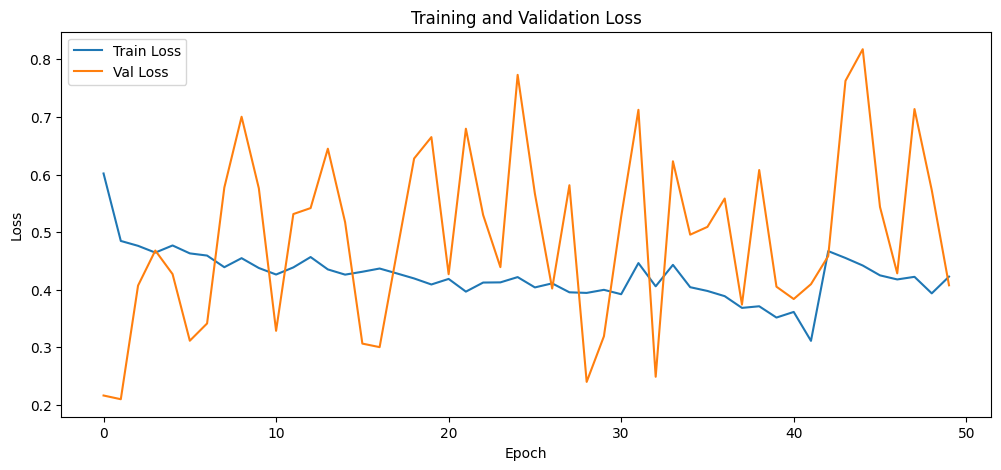

In [30]:
# Plot the training and validation losses

plt.figure(figsize=(12, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [31]:
best_model.eval()

all_preds = []
all_timestamps = []

with torch.no_grad():
    for batch_x, _ in test_loader:
        predictions = best_model(batch_x.float())

        # Convert predictions to numpy
        preds_np = predictions.cpu().numpy()
        all_preds.append(preds_np)

# Concatenate all batches
all_preds = np.concatenate(all_preds, axis=0)

all_preds_inv = scaler.inverse_transform(all_preds)


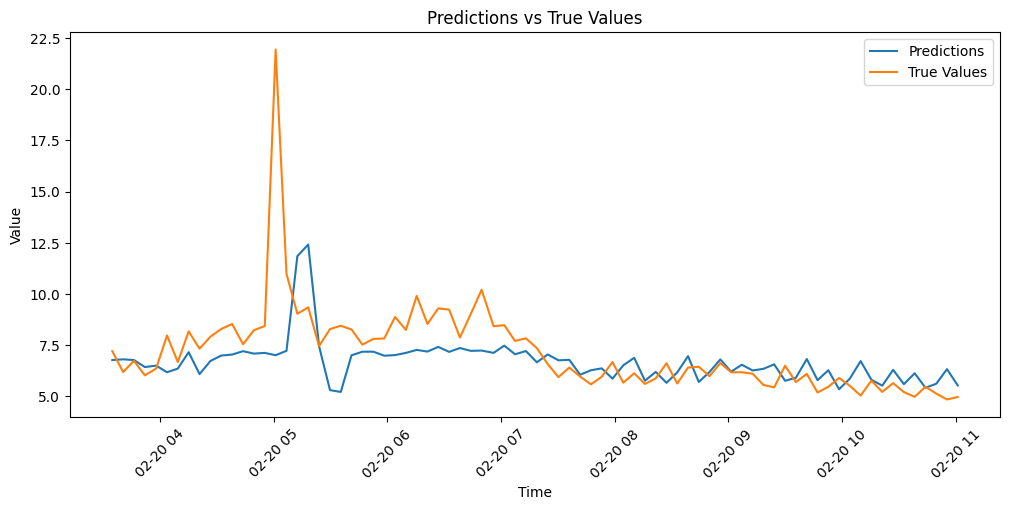

In [32]:
test_timestamps = test_data["epoch"].values[SEQ_LEN + PRED_LEN :]

true_values = scaler.inverse_transform(
    test_data["value"].values[SEQ_LEN + PRED_LEN :].reshape(-1, 1)
)

plt.figure(figsize=(12, 5))
plt.plot(test_timestamps, all_preds_inv, label="Predictions")
plt.plot(test_timestamps, true_values, label="True Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Predictions vs True Values")
plt.xticks(rotation=45)
plt.legend()
plt.show()
